# Example of ai agent approach using langchain

In [1]:
%pip install langchain langchain-community langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### Example 1: llm with tools (no agent)

In [3]:
import os
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool

llm = AzureChatOpenAI(
    openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
)

@tool
def sum_all_numbers(numbers):
    """
    This tool takes a list of numbers and returns their sum.

    Args:
        numbers (list): A list of numbers to be summed.

    Returns:
        int: The sum of all numbers in the list.
    """
    return sum(numbers)

tools = [sum_all_numbers]

llm_with_tools = llm.bind_tools(tools)

user_input = "What is the sum of 1, 2, 3, 4, 5?"
result = llm_with_tools.invoke(user_input)
print(result.tool_calls)

[{'name': 'sum_all_numbers', 'args': {'numbers': [1, 2, 3, 4, 5]}, 'id': 'call_c7ZBQTlQxoXhAbF3B4TJFoiO', 'type': 'tool_call'}]


### Example 2: Tools Agent

In [4]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant"),
    ("human", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

agent = create_tool_calling_agent(llm, tools, prompt)
executor = AgentExecutor(agent=agent, tools=tools)

# Change to streaming output
for chunk in executor.stream({"input": "What is the sum of 1, 2, 3, 4, 5?"}):
    print(chunk)

print("===")

# Change to streaming output
for chunk in executor.stream({"input": "Hi There, how are you?"}):
    print(chunk)


{'actions': [ToolAgentAction(tool='sum_all_numbers', tool_input={'numbers': [1, 2, 3, 4, 5]}, log="\nInvoking: `sum_all_numbers` with `{'numbers': [1, 2, 3, 4, 5]}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_al4YZ3FWPeib6Jw966zfsCzr', 'function': {'arguments': '{"numbers":[1,2,3,4,5]}', 'name': 'sum_all_numbers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-56ba4a30-6d49-4577-becb-cd2d15dc1521', tool_calls=[{'name': 'sum_all_numbers', 'args': {'numbers': [1, 2, 3, 4, 5]}, 'id': 'call_al4YZ3FWPeib6Jw966zfsCzr', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'sum_all_numbers', 'args': '{"numbers":[1,2,3,4,5]}', 'id': 'call_al4YZ3FWPeib6Jw966zfsCzr', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_al4YZ3FWPeib6Jw966zfsCzr')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [

### Example 3: ReAct agent (from langgraph)

In [5]:
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.


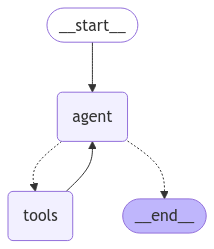

{'agent': {'messages': [AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with anything you need. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 83, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'seve

In [6]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

agent_executor = create_react_agent(llm, tools)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

for chunk in agent_executor.stream({"messages": "Hi, how are you?"}):
    print(chunk)

print("===")

for chunk in agent_executor.stream({"messages": "What is the sum of 1, 2, 3, 4, 5?"}):
    print(chunk)


### Example 4: ReAct search with Azure AI Search

In [7]:
%pip install azure-search-documents

  Using cached azure_search_documents-11.5.2-py3-none-any.whl.metadata (23 kB)
  Using cached azure_core-1.32.0-py3-none-any.whl.metadata (39 kB)
  Using cached azure_common-1.1.28-py2.py3-none-any.whl.metadata (5.0 kB)
  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
Using cached azure_search_documents-11.5.2-py3-none-any.whl (298 kB)
Using cached azure_common-1.1.28-py2.py3-none-any.whl (14 kB)
Using cached azure_core-1.32.0-py3-none-any.whl (198 kB)
Using cached isodate-0.7.2-py3-none-any.whl (22 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import json
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents._generated.models import QueryType

client = SearchIndexClient(
    endpoint=os.getenv("AZURE_SEARCH_ENDPOINT"), 
    credential=AzureKeyCredential(key=os.getenv("AZURE_AI_SEARCH_API_KEY"))
    )
index_details = client.get_index(os.getenv("AZURE_AI_SEARCH_INDEX_NAME"))

@tool
def search_index(query):
    """
    This tool searches the Azure Search index for the given query.

    Args:
        query (str): The query to search for.

    Returns:
        dict: The search results.
    """
    search_client = client.get_search_client(index_name=os.getenv("AZURE_AI_SEARCH_INDEX_NAME"))
    search_fields = [field.name for field in index_details.fields]
    search_results = search_client.search(
            search_text=query, 
            query_type=QueryType.SIMPLE,
            top=10,
            select=search_fields,
        )
    documents = [{
            "filename": i['title'],
            "content": i['chunk'],
            "score": i['@search.score'],
            "metadata": i['metadata']
        } for i in search_results]
    return documents

result = search_index("what is react")
for item in result:
    print(item)

{'filename': 'react-beginners-handbook.pdf', 'content': 'Every React component can have its own state.  \nWhat do we mean by state? The state is the set of\ndata that is managed by the component.  \nThink about a form, for example. Each individual input\nelement of the form is responsible for managing its\nstate: what is written inside it.  \nA button is responsible for knowing if it\'s being clicked,\nor not. If it\'s on focus.  \nA link is responsible for knowing if the mouse is\nhovering it.  \nIn React, or in any other components-based\nframework/library, all our applications are based and\nmake heavy use of components state.  \nWe manage state using the useState utility provided\nby React. It\'s technically a hook (you don\'t need to\nknow the details of hooks right now, but that\'s what it\nis).  \nYou import useState from React in this way:  \nimport React, { useState } from \'react\'  \nCalling useState() , you will get back a new state\nvariable, an a function that we can call

/var/folders/3r/yhlm7lp11kb8brr3yx1g1l500000gp/T/ipykernel_19373/1517218346.py:39: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = search_index("what is react")


In [9]:
from langchain_core.messages.tool import ToolMessage

def display_stream(stream):
    for chunk in stream:
        chunk["messages"][-1].pretty_print()

def display_stream_message(stream_output):
    for chunk in stream_output:
        current = chunk[0]
        if isinstance(current, ToolMessage):
            print("Tool called: ", current.name)
            # print("Tool response: ", current.content)
            # search_results = json.loads(current.content)
            # for item in search_results:
            #     print("Filename: ", item["filename"])
            #     print("Score: ", item["score"])
            #     print("Metadata: ", item["metadata"])   
        else:
            print(current.content, end="")
    print()


In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

tools = [search_index]

prompt = """You are helpful assistant. You should use search_index tool to search for the query in the Azure Search index for any query you receive."""

agent_executor = create_react_agent(llm, tools, checkpointer=memory, version="v2", prompt=prompt)

config = {"configurable": {"thread_id": "abc123"}}

display_stream_message(agent_executor.stream({"messages": "Hi, My name is Kan"}, stream_mode="messages", config=config))
display_stream_message(agent_executor.stream({"messages": "What is my name?"}, stream_mode="messages", config=config))
display_stream_message(agent_executor.stream({"messages": "what is react?"}, stream_mode="messages", config=config))
display_stream_message(agent_executor.stream({"messages": "how react handle dom event?"}, stream_mode="messages", config=config))


Hello Kan! How can I assist you today?
Your name is Kan.
Tool called:  search_index
React is a JavaScript library developed by Facebook, aimed at simplifying the development of visual interfaces. Released in 2013, it powers some of the most widely used applications, including Facebook and Instagram. React's main goal is to make it easy to reason about an interface and its state at any point in time by dividing the UI into a collection of components.

To get started with React, you need to understand a few core concepts:
- **Components**: The building blocks of a React application.
- **JSX**: A syntax extension for JavaScript which looks similar to HTML and is used in React.
- **State**: An object that determines how the component renders and behaves.
- **Props**: Short for properties, props allow you to pass data from parent to child components.

React's ecosystem is filled with great libraries and tools that enhance the development experience, and it provides an easy way to manage eve

In [11]:
# Passing with message history
message_history = [
    { "role": "system", "content": "You are a helpful assistant."},
    { "role": "human", "content": "Hi I am Kan"},
    { "role": "assistant", "content": "Hello Kan! How can I assist you today?"},
]

config = {"configurable": {"thread_id": "def456"}}

# display_stream_message(agent_executor.stream({"messages": "Hi, My name is Kan"}, stream_mode="messages", config=config))
display_stream_message(agent_executor.stream({"messages": message_history + [("human", "What is my name?")]}, stream_mode="messages", config=config))


Your name is Kan.


In [12]:
from langchain_community.retrievers import AzureAISearchRetriever
search_fields = [field.name for field in index_details.fields]
search_tool = AzureAISearchRetriever(
    content_key="chunk",
    top_k=10,
    index_name=os.getenv("AZURE_SEARCH_INDEX_NAME")
)

search_tool.invoke("react vs jsx")


[Document(metadata={'@search.score': 2.1420665, 'chunk_id': 'HM7Z5OPi_c9qi6ncNcHYWdmYJBpcv47eXl5zlTDhH9bylZvnaWU5c6RbMtNsYBUaqMHB3izwF864PMwCSYiLb1HbF2xWdzVdp2h1vO4z8XJPvd8XB6tV4moBzp10HsrkRGLijsg7QLP4M7HqpgezkvVssKMr4o3gDMgfrymPQre63I696wjRaTMiYuu9oxq2hicbx', 'parent_id': 'c9qi6ncNcHYWdmYJBpcv47eXl5zlTDhH9bylZvnaWU5c6RbMtNsYBUaqMHB3izwF864PMwCSYiLb1HbF2xWdzVdp2h1vO4z8XJPvd8XB6tV4moBzp10HsrkRGLijsg7QLP4M7HqpgezkvVssKMr4o3gDMgfrymPQre63I696wjRaTMiYuu9oxq2hicbx', 'title': 'react-beginners-handbook.pdf', 'text_vector': [-0.042724054, -0.034784414, -0.014172386, 0.015491349, 0.0017521518, 0.0018523671, -0.012161614, 0.030180976, -0.033387866, 0.021633578, -0.021543061, 0.032612007, -0.044948187, -0.046525773, -0.007318951, -0.034862, -0.05087059, -0.027646497, -0.00055967027, -0.01524566, 0.0073965373, 0.033491313, -0.055189546, 0.02000427, -0.037758548, -0.0036756394, 0.035043035, 0.007952571, 0.024413746, 0.017017208, -0.0018491343, 0.009071103, 0.008825414, -0.05009473, -0.025784433, -0